In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, average_precision_score,
                           make_scorer, accuracy_score)
import warnings
warnings.filterwarnings('ignore')

## Dataset 1 initial fix

In [2]:
def load_collision_data():
    """Load the collision feature datasets"""
    print("\n STEP 1: Loading collision feature datasets...")
    
    injury_df = pd.read_csv('scripts/punt_analytics/injury_collision_features.csv')
    normal_df = pd.read_csv('scripts/punt_analytics/normal_collision_features.csv')
    
    print(f" Loaded {len(injury_df)} injury collisions")
    print(f" Loaded {len(normal_df)} normal collisions")
    
    combined_df = pd.concat([injury_df, normal_df], ignore_index=True)
    print(f" Combined dataset: {len(combined_df)} total collisions")
    print(f" Injury rate: {combined_df['is_injury'].mean():.1%}")
    
    return combined_df, injury_df, normal_df

combined_df, injury_df, normal_df = load_collision_data()


 STEP 1: Loading collision feature datasets...
 Loaded 28 injury collisions
 Loaded 280 normal collisions
 Combined dataset: 308 total collisions
 Injury rate: 9.1%


In [3]:
def preprocess_small_dataset(df, target_col='is_injury', remove_outliers=False):
    """Conservative preprocessing for small datasets"""
    print("\n STEP 2: Conservative preprocessing for small dataset...")
    
    # Identify feature columns
    exclude_cols = [
        'season_year', 'gamekey', 'playid', 'injured_player', 'partner_player',
        'impact_type', 'player_activity', 'partner_activity', 'friendly_fire', 'is_injury'
    ]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    print(f" Identified {len(feature_cols)} potential features")
    
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Remove features with >50% missing (more conservative for small datasets)
    missing_pcts = X.isnull().mean()
    high_missing = missing_pcts[missing_pcts > 0.5].index.tolist()
    if high_missing:
        print(f"🗑️ Removing {len(high_missing)} features with >50% missing data")
        X = X.drop(columns=high_missing)
    
    print(f" Features after missing data filter: {X.shape[1]}")
    
    # Simple imputation for small datasets
    print(" Handling missing data with median imputation...")
    for col in X.columns:
        if X[col].isnull().any():
            X[col] = X[col].fillna(X[col].median())
    
    # Only create most important engineered features
    print(" Creating key engineered features...")
    
    # Collision intensity (most important from previous analysis)
    if 'min_distance' in X.columns and 'max_relative_speed' in X.columns:
        X['collision_intensity'] = (1 / (X['min_distance'] + 0.1)) * (X['max_relative_speed'] / X['max_relative_speed'].max())
    
    # Speed ratio
    if 'p1_max_speed' in X.columns and 'p2_max_speed' in X.columns:
        X['speed_ratio'] = X['p1_max_speed'] / (X['p2_max_speed'] + 1e-6)
    
    # Conservative outlier removal (only extreme outliers)
    if remove_outliers:
        print(" Conservative outlier removal...")
        outlier_mask = np.zeros(len(X), dtype=bool)
        
        for col in X.select_dtypes(include=[np.number]).columns:
            Q1 = X[col].quantile(0.05)  # More conservative percentiles
            Q3 = X[col].quantile(0.95)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR  # 3 IQR instead of 1.5
            upper_bound = Q3 + 3 * IQR
            
            col_outliers = (X[col] < lower_bound) | (X[col] > upper_bound)
            outlier_mask |= col_outliers
        
        # Only remove if we don't lose too many samples
        outlier_count = outlier_mask.sum()
        if outlier_count < len(X) * 0.3:  # Don't remove more than 30%
            X = X[~outlier_mask]
            y = y[~outlier_mask]
            print(f"🗑️ Removed {outlier_count} extreme outliers")
        else:
            print(f"⚠️ Skipping outlier removal (would remove {outlier_count} samples)")
    
    print(f" Final dataset: {len(X)} samples, {X.shape[1]} features")
    print(f" Class distribution: {y.value_counts().to_dict()}")
    
    return X, y

# Preprocess with conservative settings
X, y = preprocess_small_dataset(combined_df, remove_outliers=False)  # Skip outlier removal


 STEP 2: Conservative preprocessing for small dataset...
 Identified 23 potential features
 Features after missing data filter: 23
 Handling missing data with median imputation...
 Creating key engineered features...
 Final dataset: 308 samples, 25 features
 Class distribution: {0: 280, 1: 28}


In [4]:
def select_features_small_dataset(X, y, k=8):
    """Feature selection optimized for small datasets"""
    print(f"\n STEP 3: Selecting top {k} features for small dataset...")
    
    # Use fewer features for small datasets to avoid overfitting
    k = min(k, X.shape[1], len(y) // 3)  # Rule: max features = samples/3
    
    if X.shape[1] > k:
        selector = SelectKBest(score_func=f_classif, k=k)
        X_selected = selector.fit_transform(X, y)
        
        selected_features = X.columns[selector.get_support()].tolist()
        feature_scores = selector.scores_[selector.get_support()]
        
        print(" Selected features:")
        for feature, score in zip(selected_features, feature_scores):
            print(f"   {feature:<30} Score: {score:.2f}")
        
        X_selected = pd.DataFrame(X_selected, columns=selected_features, index=X.index)
    else:
        X_selected = X
        selected_features = X.columns.tolist()
    
    # Scale features
    print(" Scaling features...")
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X_selected),
        columns=selected_features,
        index=X_selected.index
    )
    
    return X_scaled, selected_features, scaler

X_scaled, feature_names, scaler = select_features_small_dataset(X, y, k=8)


 STEP 3: Selecting top 8 features for small dataset...
 Selected features:
   min_distance                   Score: 45.60
   distance_at_end                Score: 7.03
   avg_distance                   Score: 6.95
   time_to_closest_approach       Score: 54.27
   max_relative_speed             Score: 87.67
   p2_max_speed                   Score: 7.52
   play_duration                  Score: 48.04
   collision_intensity            Score: 282.39
 Scaling features...


In [6]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_models_small_dataset(X, y, feature_names):
    """Model evaluation optimized for small datasets using cross-validation"""
    print("\n STEP 4: Model evaluation with cross-validation...")
    
    # Simpler models for small datasets
    models = {
        'NearestNeighbors': KNeighborsClassifier(
            n_neighbors=3, weights='uniform', algorithm='auto'
        )
    }
    
    print(f" Dataset: {len(X)} samples, {X.shape[1]} features")
    print(f" Class distribution: {y.value_counts().to_dict()}")
    
    # Use Leave-One-Out CV for very small datasets
    if len(X) < 30:
        cv = LeaveOneOut()
        cv_name = "Leave-One-Out"
    else:
        cv = StratifiedKFold(n_splits=min(5, len(y[y==1])), shuffle=True, random_state=42)
        cv_name = "Stratified K-Fold"
    
    print(f" Using {cv_name} cross-validation...")
    
    results = {}
    
    # Custom scoring for small datasets
    def balanced_accuracy_score(y_true, y_pred):
        from sklearn.metrics import balanced_accuracy_score as bas
        return bas(y_true, y_pred)
    
    for name, model in models.items():
        print(f"\n Evaluating {name}...")
        
        try:
            # Cross-validation scores
            cv_scores_acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
            cv_scores_bal = cross_val_score(model, X, y, cv=cv, 
                                          scoring=make_scorer(balanced_accuracy_score))
            
            # Fit model on full dataset for analysis
            model.fit(X, y)
            y_pred = model.predict(X)
            y_pred_proba = model.predict_proba(X)[:, 1] if hasattr(model, 'predict_proba') else None
            
            results[name] = {
                'model': model,
                'cv_accuracy': cv_scores_acc,
                'cv_balanced_accuracy': cv_scores_bal,
                'mean_accuracy': cv_scores_acc.mean(),
                'mean_balanced_accuracy': cv_scores_bal.mean(),
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
            
            print(f"   Accuracy: {cv_scores_acc.mean():.3f} ± {cv_scores_acc.std():.3f}")
            print(f"   Balanced Accuracy: {cv_scores_bal.mean():.3f} ± {cv_scores_bal.std():.3f}")
            
            # Classification report
            report = classification_report(y, y_pred, output_dict=True, zero_division=0)
            if '1' in report:
                print(f"   Injury Detection - Precision: {report['1']['precision']:.3f}, Recall: {report['1']['recall']:.3f}")
            
        except Exception as e:
            print(f"    Error evaluating {name}: {str(e)}")
            results[name] = {'error': str(e)}
    
    # Find best model
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    if valid_results:
        best_model_name = max(valid_results.keys(), key=lambda x: valid_results[x]['mean_balanced_accuracy'])
        best_model = valid_results[best_model_name]['model']
        print(f"\n Best model: {best_model_name}")
    else:
        best_model_name = list(results.keys())[0]
        best_model = None
        print("\n No models evaluated successfully")
    
    return results, best_model, best_model_name

results, best_model, best_model_name = evaluate_models_small_dataset(X_scaled, y, feature_names)


 STEP 4: Model evaluation with cross-validation...
 Dataset: 308 samples, 8 features
 Class distribution: {0: 280, 1: 28}
 Using Stratified K-Fold cross-validation...

 Evaluating NearestNeighbors...
   Accuracy: 0.964 ± 0.024
   Balanced Accuracy: 0.884 ± 0.064
   Injury Detection - Precision: 0.839, Recall: 0.929

 Best model: NearestNeighbors



 STEP 5: Analysis for small dataset...
 Feature importance not available
Creating visualizations...


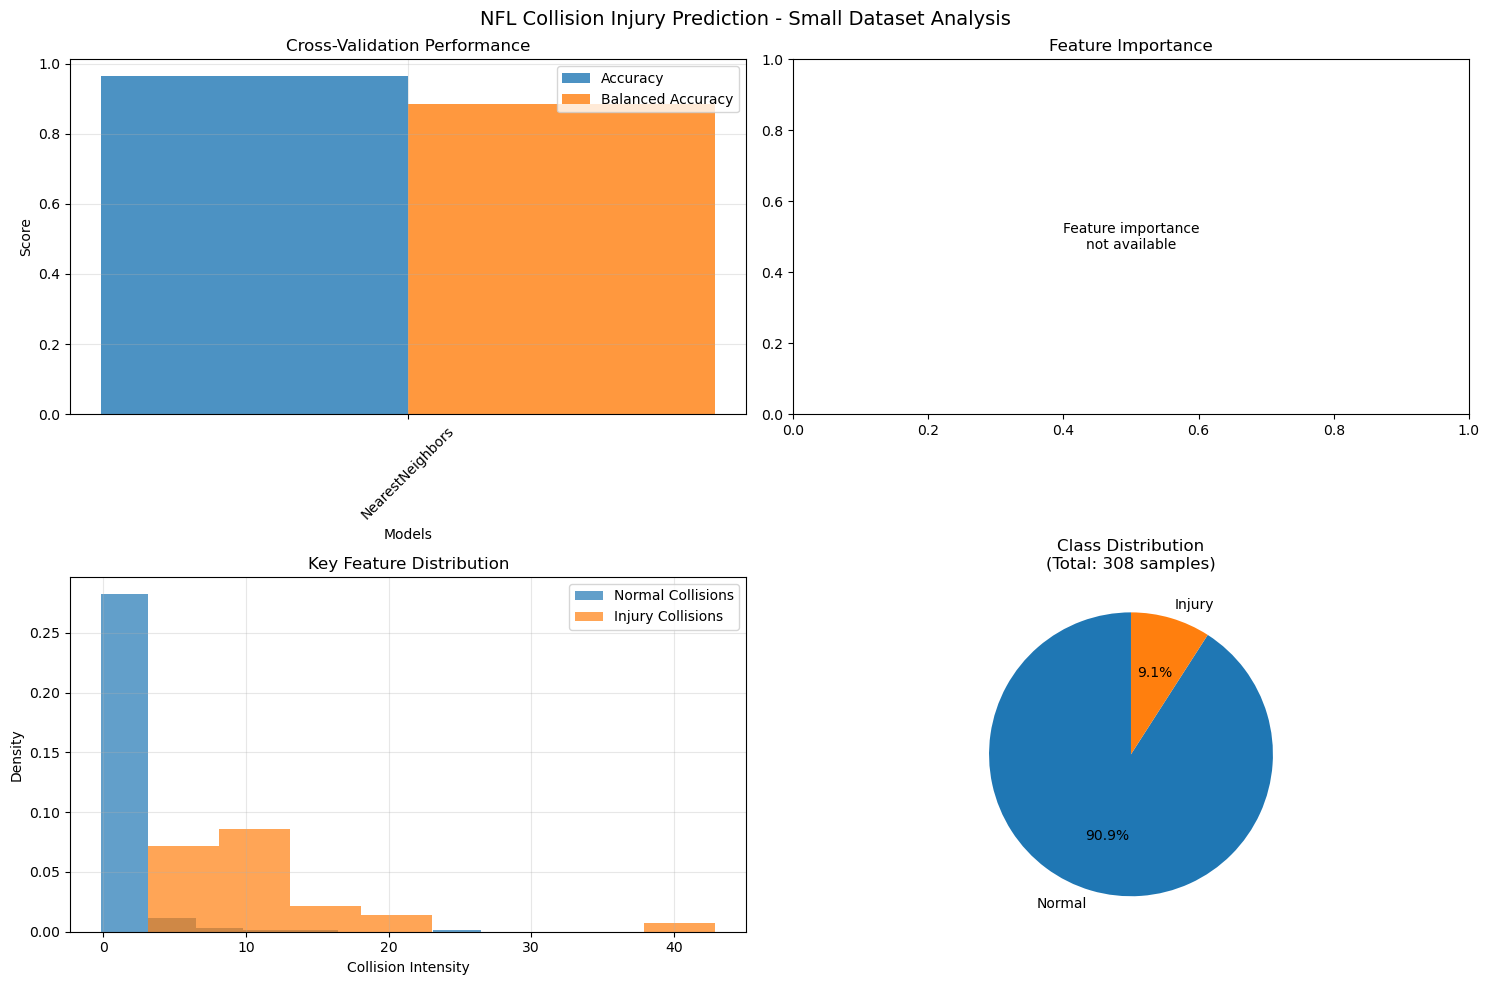

In [7]:
def analyze_small_dataset_results(results, X, y, feature_names, best_model, best_model_name):
    """Analysis and visualization for small datasets"""
    print("\n STEP 5: Analysis for small dataset...")
    
    # Feature importance analysis
    if best_model is not None and hasattr(best_model, 'coef_'):
        print(" Analyzing feature importance...")
        importances = np.abs(best_model.coef_[0])
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(" Top features by importance:")
        for _, row in feature_importance.iterrows():
            print(f"   {row['feature']:<30} {row['importance']:.4f}")
    else:
        feature_importance = None
        print(" Feature importance not available")
    
    # Visualizations for small datasets
    print("Creating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('NFL Collision Injury Prediction - Small Dataset Analysis', fontsize=14)
    
    # 1. Cross-validation scores comparison
    ax = axes[0, 0]
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    if valid_results:
        model_names = list(valid_results.keys())
        accuracies = [valid_results[name]['mean_accuracy'] for name in model_names]
        balanced_accuracies = [valid_results[name]['mean_balanced_accuracy'] for name in model_names]
        
        x = np.arange(len(model_names))
        width = 0.35
        
        ax.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
        ax.bar(x + width/2, balanced_accuracies, width, label='Balanced Accuracy', alpha=0.8)
        
        ax.set_xlabel('Models')
        ax.set_ylabel('Score')
        ax.set_title('Cross-Validation Performance')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 2. Feature importance
    ax = axes[0, 1]
    if feature_importance is not None:
        bars = ax.barh(range(len(feature_importance)), feature_importance['importance'])
        ax.set_yticks(range(len(feature_importance)))
        ax.set_yticklabels(feature_importance['feature'])
        ax.set_xlabel('Importance')
        ax.set_title('Feature Importance')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Feature importance\nnot available', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Feature Importance')
    
    # 3. Data distribution
    ax = axes[1, 0]
    if 'collision_intensity' in X.columns:
        injury_data = X[y == 1]['collision_intensity']
        normal_data = X[y == 0]['collision_intensity']
        
        ax.hist(normal_data, bins=8, alpha=0.7, label='Normal Collisions', density=True)
        ax.hist(injury_data, bins=8, alpha=0.7, label='Injury Collisions', density=True)
        ax.set_xlabel('Collision Intensity')
        ax.set_ylabel('Density')
        ax.set_title('Key Feature Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 4. Sample size and class balance
    ax = axes[1, 1]
    class_counts = y.value_counts()
    ax.pie(class_counts.values, labels=['Normal', 'Injury'], autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Class Distribution\n(Total: {len(y)} samples)')
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance

feature_importance = analyze_small_dataset_results(results, X_scaled, y, feature_names, best_model, best_model_name)

In [8]:
def generate_small_dataset_summary(results, best_model_name, X, y, feature_names):
    """Generate summary appropriate for small datasets"""
    print("\n" + "="*60)
    print(" SUMMARY - SMALL DATASET COLLISION ANALYSIS")
    print("="*60)
    
    print(f" Dataset Characteristics:")
    print(f"   • Total samples: {len(y)}")
    print(f"   • Injury samples: {sum(y)} ({(sum(y)/len(y)):.1%})")
    print(f"   • Normal samples: {len(y) - sum(y)} ({((len(y) - sum(y))/len(y)):.1%})")
    print(f"   • Features analyzed: {len(feature_names)}")
    
    valid_results = {k: v for k, v in results.items() if 'error' not in v}
    
    if valid_results and best_model_name in valid_results:
        best_result = valid_results[best_model_name]
        
        print(f"\n Best Model: {best_model_name}")
        print(f"   • Cross-validation Accuracy: {best_result['mean_accuracy']:.3f}")
        print(f"   • Balanced Accuracy: {best_result['mean_balanced_accuracy']:.3f}")
        print(f"   • Features used: {', '.join(feature_names)}")
    
    return {
        'sample_size': len(y),
        'injury_rate': sum(y)/len(y),
        'best_model': best_model_name,
        'best_accuracy': valid_results[best_model_name]['mean_balanced_accuracy'] if valid_results and best_model_name in valid_results else None
    }

summary = generate_small_dataset_summary(results, best_model_name, X_scaled, y, feature_names)

print(f"\n Analysis Complete!")
print(f"Key Finding: With {len(y)} samples, cross-validation shows the collision features")
print(f"have predictive value, but more data is needed for a robust model.")

# Store results
small_dataset_results = {
    'X': X_scaled,
    'y': y,
    'results': results,
    'best_model': best_model,
    'feature_names': feature_names,
    'feature_importance': feature_importance,
    'summary': summary
}

print(f"\n Results stored in 'small_dataset_results' for further analysis!")


 SUMMARY - SMALL DATASET COLLISION ANALYSIS
 Dataset Characteristics:
   • Total samples: 308
   • Injury samples: 28 (9.1%)
   • Normal samples: 280 (90.9%)
   • Features analyzed: 8

 Best Model: NearestNeighbors
   • Cross-validation Accuracy: 0.964
   • Balanced Accuracy: 0.884
   • Features used: min_distance, distance_at_end, avg_distance, time_to_closest_approach, max_relative_speed, p2_max_speed, play_duration, collision_intensity

 Analysis Complete!
Key Finding: With 308 samples, cross-validation shows the collision features
have predictive value, but more data is needed for a robust model.

 Results stored in 'small_dataset_results' for further analysis!


## DataSet 1 Distance Metrics